In [1]:
SEED = 42
import os
os.environ['PYTHONHASHSEED'] = str(SEED)
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

def reset_seeds():
    np.random.seed(SEED)  # Establecer la semilla para el generador de números aleatorios de Numpy
    tf.random.set_seed(SEED)  # Establecer la semilla para el generador de números aleatorios de TensorFlow
    random.seed(SEED)  # Establecer la semilla para el generador de números aleatorios de Python

reset_seeds()

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Ruta al directorio del conjunto de datos de validación
train_loc_vgg19 = './OfficialSpectrogramsMelAUG/train'
test_loc_vgg19 = './OfficialSpectrogramsMelAUG/test'

train_loc_vgg16 = './OfficialSpectrogramsMelAUG/train'
test_loc_vgg16 = './OfficialSpectrogramsMelAUG/test'

# Definir la normalización
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

# Crear los generadores de datos para VGG19
train_generator_vgg19 = train_datagen.flow_from_directory(
    directory=train_loc_vgg19,
    target_size=(224, 224),
    shuffle=True,
    seed=SEED
)

test_generator_vgg19 = test_datagen.flow_from_directory(
    directory=test_loc_vgg19,
    target_size=(224, 224),
    shuffle=False,
    seed=SEED
)

# Crear los generadores de datos para VGG16
train_generator_vgg16 = train_datagen.flow_from_directory(
    directory=train_loc_vgg16,
    target_size=(224, 224),
    shuffle=True,
    seed=SEED
)

test_generator_vgg16 = test_datagen.flow_from_directory(
    directory=test_loc_vgg16,
    target_size=(224, 224),
    shuffle=False,
    seed=SEED
)

# Crear un generador combinado para los datos de validación
def combined_generator(generator1, generator2):
    while True:
        batch1 = next(generator1)
        batch2 = next(generator2)
        yield [batch1[0], batch2[0]], batch1[1]

validation_combined_generator = combined_generator(test_generator_vgg19, test_generator_vgg16)

# Cargar el modelo guardado
model = load_model('./Best_Models/Tests/RMSprop/Custom_RMSprop_00005')

# Evaluar el modelo en el conjunto de datos de validación
steps = test_generator_vgg19.samples // test_generator_vgg19.batch_size
loss, accuracy = model.evaluate(validation_combined_generator, steps=steps)
print("Validation loss:", loss)
print("Validation accuracy:", accuracy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4090, compute capability 8.9
Found 8544 images belonging to 4 classes.
Found 2756 images belonging to 4 classes.
Found 8544 images belonging to 4 classes.
Found 2756 images belonging to 4 classes.
86/86 [==============================] - 13s 132ms/step - loss: 1.2894 - accuracy: 0.5312
Validation loss: 1.2894116640090942
Validation accuracy: 0.53125


In [2]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

validation_steps = test_generator_vgg19.samples // test_generator_vgg19.batch_size

# Predicciones en el conjunto de prueba
predictions = model.predict(validation_combined_generator, steps=validation_steps)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator_vgg19.classes[:len(predictions)]  # Asegúrate de que la longitud coincida

# Convertir las predicciones en etiquetas de clase
y_pred_classes = np.argmax(predictions, axis=1)

# Calcular métricas
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Mostrar las métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Obtener el número total de predicciones correctas para cada clase
Pc = sum((y_true == 0) & (y_pred_classes == 0))  # Crackle
Pb = sum((y_true == 1) & (y_pred_classes == 1))  # Both
Pn = sum((y_true == 2) & (y_pred_classes == 2))  # Normal
Pw = sum((y_true == 3) & (y_pred_classes == 3))  # Wheeze

# Obtener el total de muestras para cada clase
Crackle_total = sum(y_true == 0)  # Total de muestras de la clase Crackle
Both_total = sum(y_true == 1)     # Total de muestras de la clase Both
Normal_total = sum(y_true == 2)   # Total de muestras de la clase Normal
Wheeze_total = sum(y_true == 3)   # Total de muestras de la clase Wheeze

# Calcular el puntaje Se (Sensibilidad)
Se = (Pc + Pw + Pb) / (Crackle_total + Wheeze_total + Both_total)

# Calcular el puntaje Sp (Especificidad)
Sp = Pn / Normal_total

# Calcular el puntaje promedio
score = (Se + Sp) / 2

# Mostrar los resultados
print("Puntaje de Sensibilidad (Se):", Se)
print("Puntaje de Especificidad (Sp):", Sp)
print("Puntaje promedio:", score)

86/86 [==============================] - 10s 110ms/step
Accuracy: 0.53125
Precision: 0.5203749013488839
Recall: 0.53125
F1 Score: 0.5204390231093107
Puntaje de Sensibilidad (Se): 0.28388746803069054
Puntaje de Especificidad (Sp): 0.7150094996833439
Puntaje promedio: 0.49944848385701723


In [3]:
# Generar el informe de clasificación
class_names = list(train_generator_vgg19.class_indices.keys())
print("Class names:", class_names)
class_report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(class_report)

Class names: ['crackle', 'crackle_wheeze', 'normal', 'wheeze']
Classification Report:
                precision    recall  f1-score   support

       crackle       0.45      0.30      0.36       649
crackle_wheeze       0.23      0.32      0.27       143
        normal       0.64      0.72      0.67      1579
        wheeze       0.27      0.25      0.26       381

      accuracy                           0.53      2752
     macro avg       0.40      0.40      0.39      2752
  weighted avg       0.52      0.53      0.52      2752



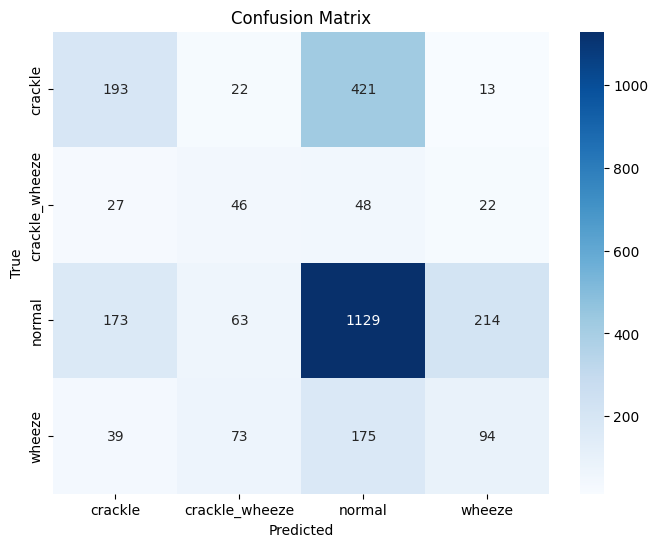

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Función para mostrar la matriz de confusión
def plot_confusion_matrix(y_true, y_pred, class_names):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Calcular y mostrar la matriz de confusión
plot_confusion_matrix(y_true, y_pred_classes, class_names)